In [1]:
%matplotlib inline
import numpy as np
import healpy as hp
import matplotlib.pylab as plt
import lsst.sims.featureScheduler as fs
from lsst.sims.utils import _hpid2RaDec
from scipy.optimize import minimize, basinhopping

In [12]:
nside = 512
current_obs = np.ones(hp.nside2npix(nside))
ra, dec = _hpid2RaDec(nside, np.arange(hp.nside2npix(nside)))
out =  np.where( (ra < np.radians(45)) | (ra > np.radians(55.)))
current_obs[out] = hp.UNSEEN
current_obs[np.where(np.abs(dec) > np.radians(7.))] = hp.UNSEEN
mask = np.where(current_obs == hp.UNSEEN)

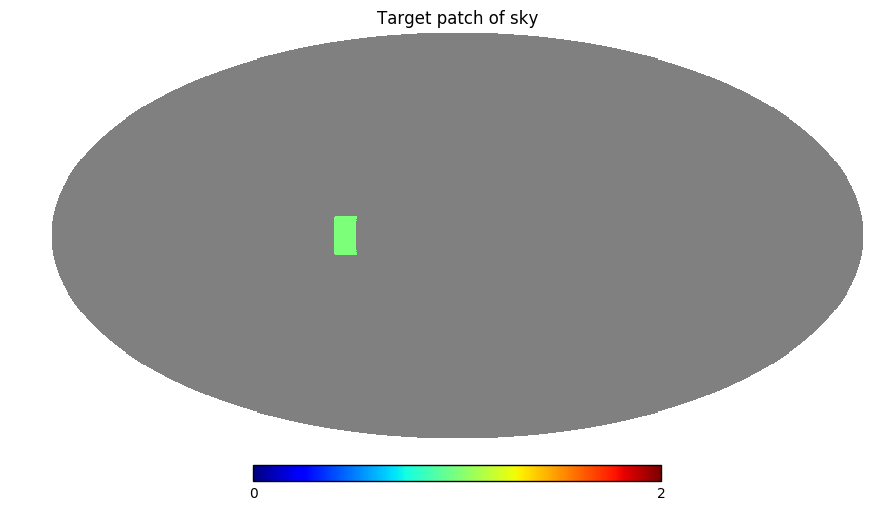

In [13]:
hp.mollview(current_obs, title='Target patch of sky')

In [14]:
hpc = fs.hpmap_cross(nside=nside)
hpc.set_map(current_obs)
print hpc([np.radians(50), np.radians(0.), 0.])

0.553400092177


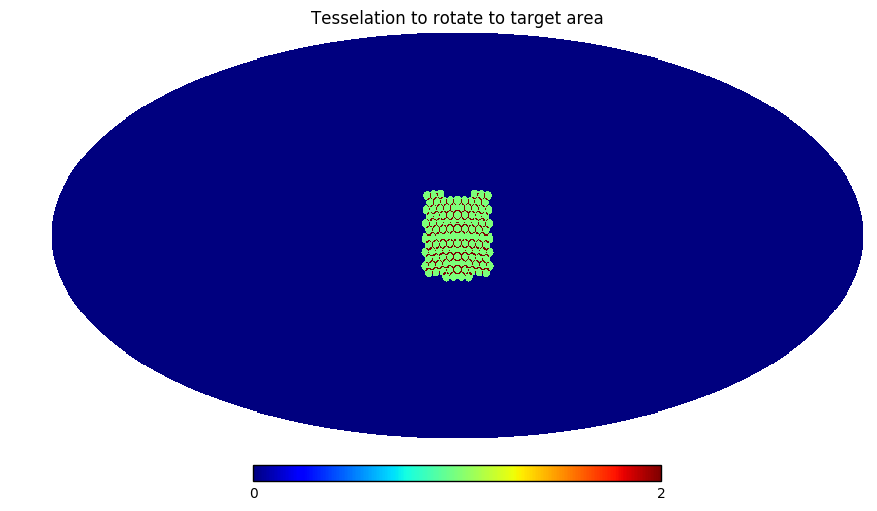

In [15]:
# Make a quick map of the full tesselation
hpc.set_map(current_obs*0+1)
p1, p2, full_map = hpc([0,0,0], return_pointings_map=True)
hp.mollview(full_map, title='Tesselation to rotate to target area')


hpc.set_map(current_obs)

In [16]:
print 'number of pointings', p1.size
area = hp.nside2pixarea(nside, degrees=True)
area_covered = area*np.size(np.where(full_map >0)[0])
print area_covered, 'sq deg'

number of pointings 114
917.177472694 sq deg


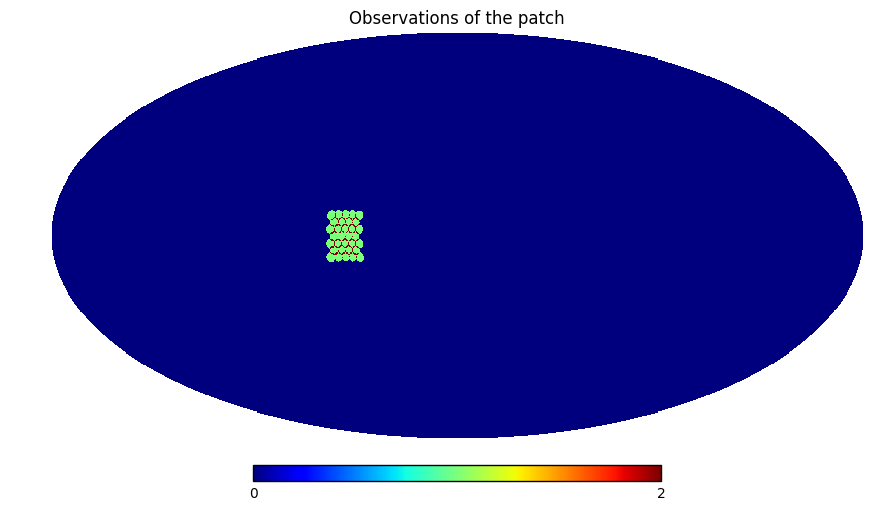

In [17]:
p1, p2, obs_map = hpc([np.radians(50.), 0., 0.], return_pointings_map=True)
hp.mollview(obs_map, title='Observations of the patch')

In [18]:
p1.size

32

In [19]:
hpc.inmap = obs_map +0.
hpc.inmap[mask] = hp.UNSEEN

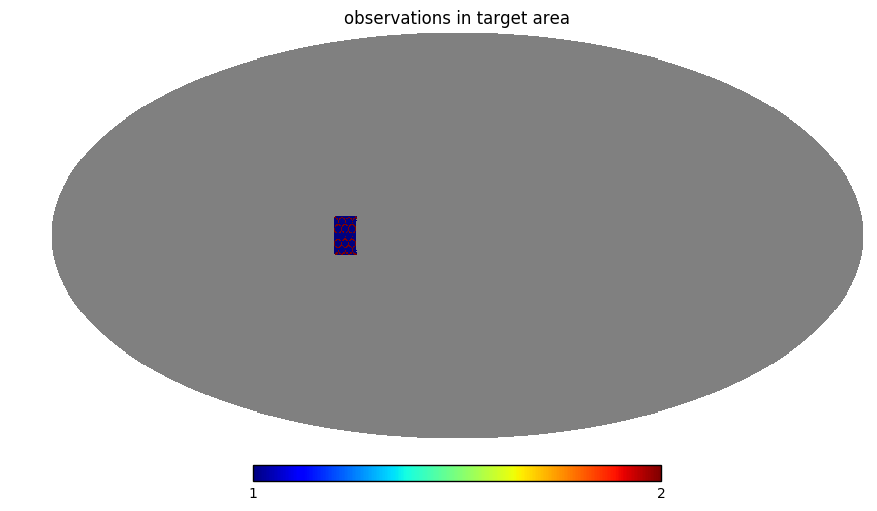

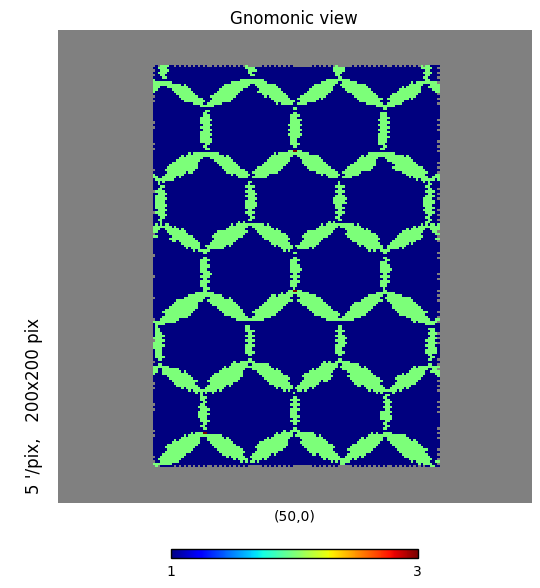

In [21]:
hp.mollview(hpc.inmap, title='observations in target area')
hp.gnomview(hpc.inmap, rot=(50, 0, 0), reso=5)

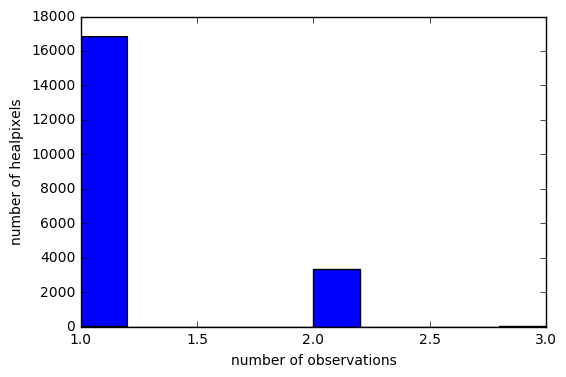

In [22]:
good = np.where(obs_map > 0)
plt.hist(obs_map[good])
plt.xlabel('number of observations')
plt.ylabel('number of healpixels')

In [23]:
hpc([np.radians(50.), np.radians(-1.), 0.])

0.60285856231130819

In [24]:
# find the next best set of pointings that cover the area and minimize the cross-correlation
ack = hpc.minimize()

In [25]:
print 'best fit rotations = ', np.degrees(ack)
print 'best-fit cross-correlation', hpc(ack)
print 'check that cross-correlation goes up if we shift best-fit', hpc(ack-.001)
print 'another check', hpc([ack[0], ack[1], np.pi/4])

best fit rotations =  [ 50.01465136  -1.44710892  -0.09121299]
best-fit cross-correlation 0.595691861131
check that cross-correlation goes up if we shift best-fit 0.597370927796
another check 0.615896811506


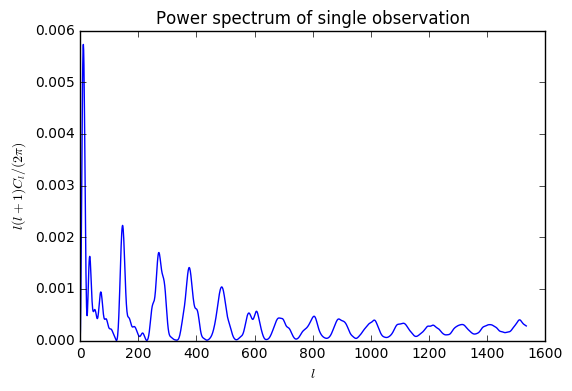

In [26]:
masked_map = obs_map.copy() +0.
#masked_map[mask] = hp.UNSEEN
cl = hp.anafast(masked_map)
ell = np.arange(np.size(cl))
plt.plot(ell, (cl * ell * (ell + 1)) / 2.0 / np.pi)
plt.xlabel(r'$l$')
plt.ylabel(r'$l(l+1)C_l/(2\pi)$')
plt.title('Power spectrum of single observation')

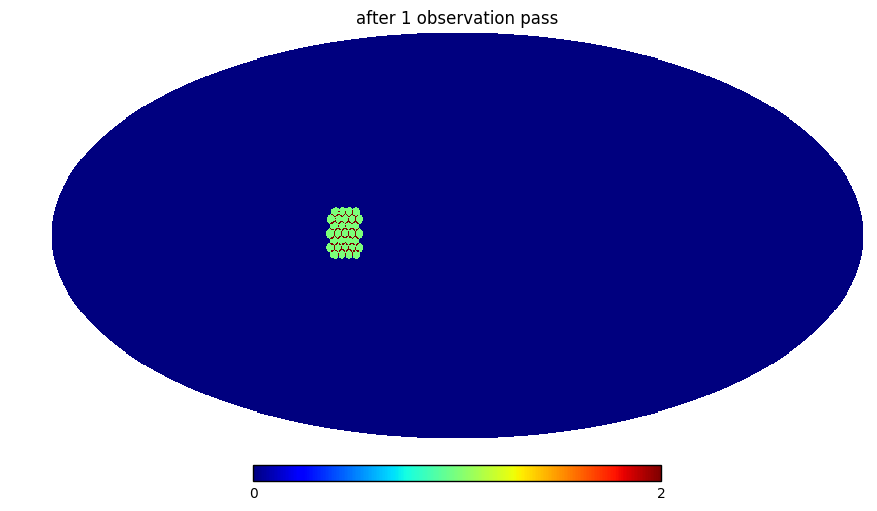

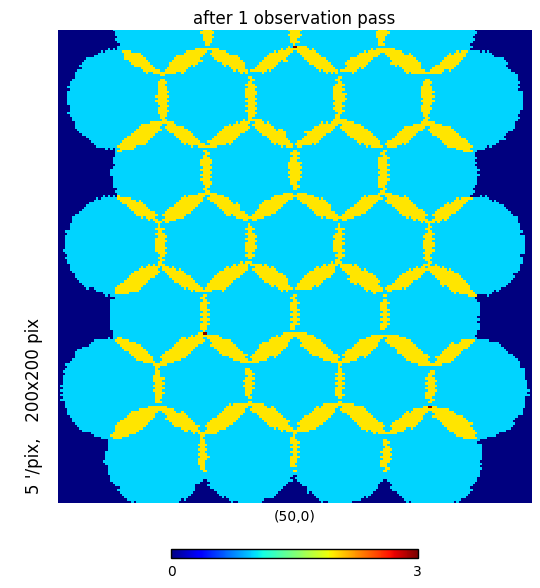

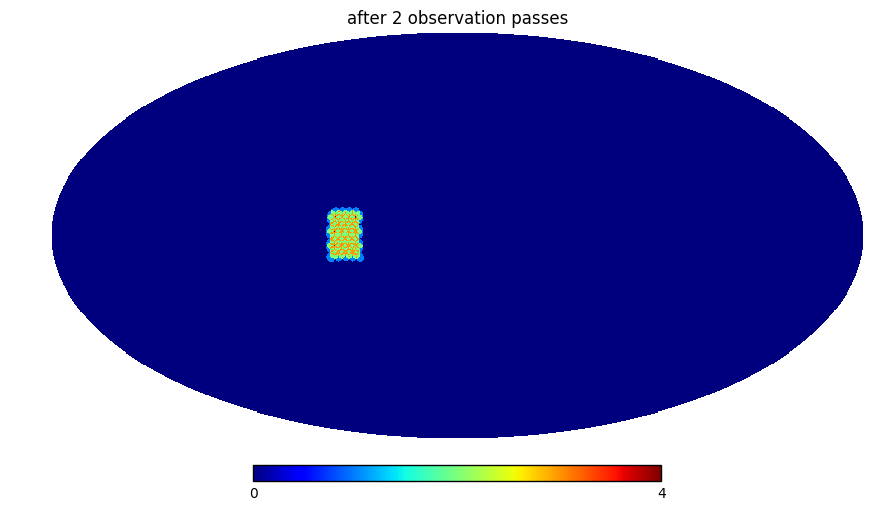

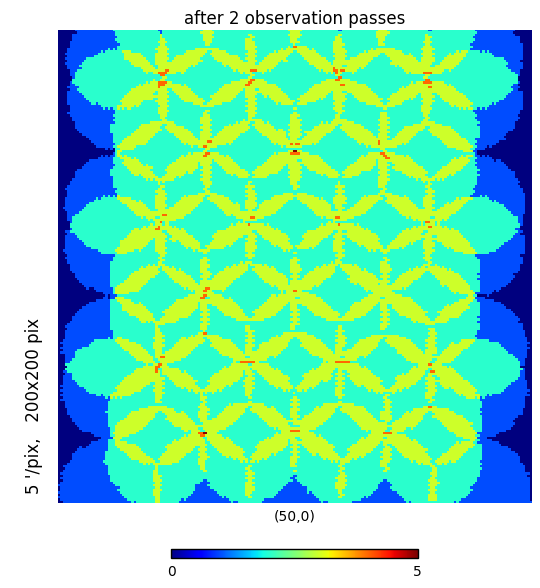

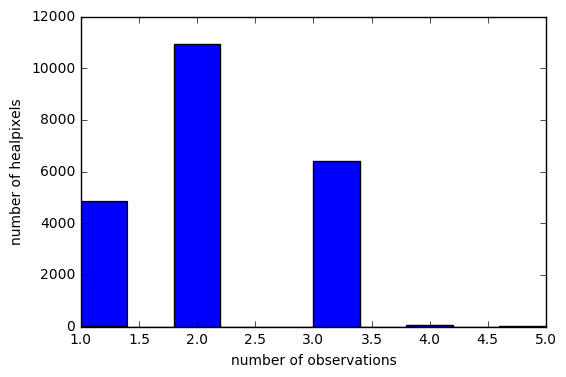

In [27]:
obs_ra, obs_dec, single_map = hpc(ack, return_pointings_map=True)
hp.mollview(single_map, title='after 1 observation pass')
hp.gnomview(single_map, rot=(50, 0, 0), reso=5. , title='after 1 observation pass')
hp.mollview(single_map + obs_map, title='after 2 observation passes')
hp.gnomview(single_map+ obs_map, rot=(50, 0, 0), reso=5, title='after 2 observation passes')
good = np.where(obs_map+single_map > 0)
plt.figure()
plt.hist(single_map[good] + obs_map[good])
plt.xlabel('number of observations')
plt.ylabel('number of healpixels')

In [28]:
# Let's observe the patch 10 times!
bfs = []
for i in np.arange(10):
    best_fit = hpc.minimize()
    bfs.append(best_fit)
    p1, p2, obs_map2 = hpc(best_fit, return_pointings_map=True)
    obs_map += obs_map2
    hpc.inmap = obs_map +0.
    hpc.inmap[mask] = hp.UNSEEN

[ 47.88826833   2.09654508  56.65777681]


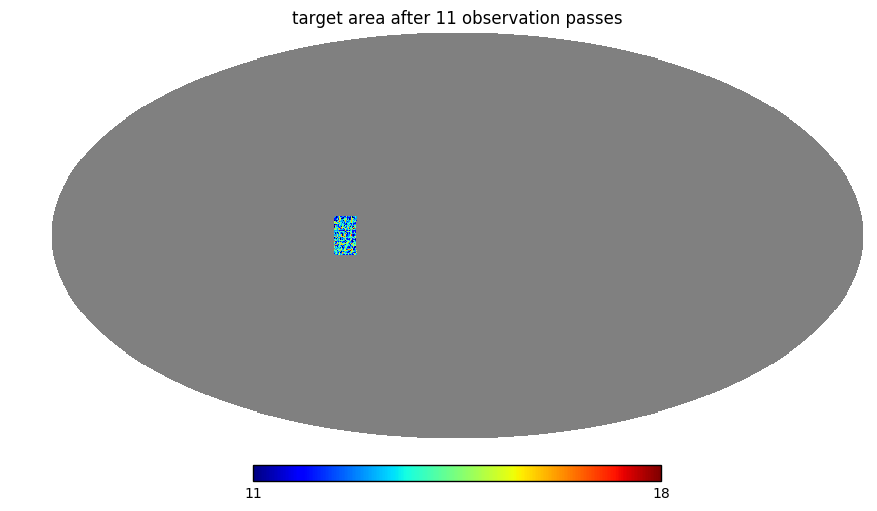

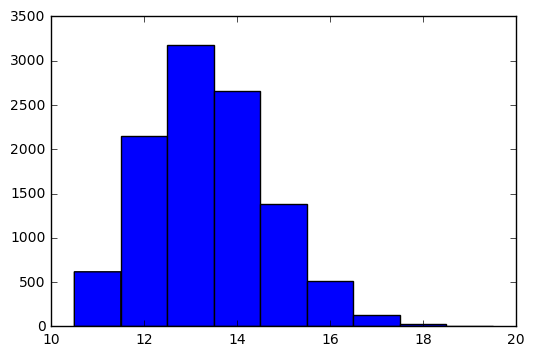

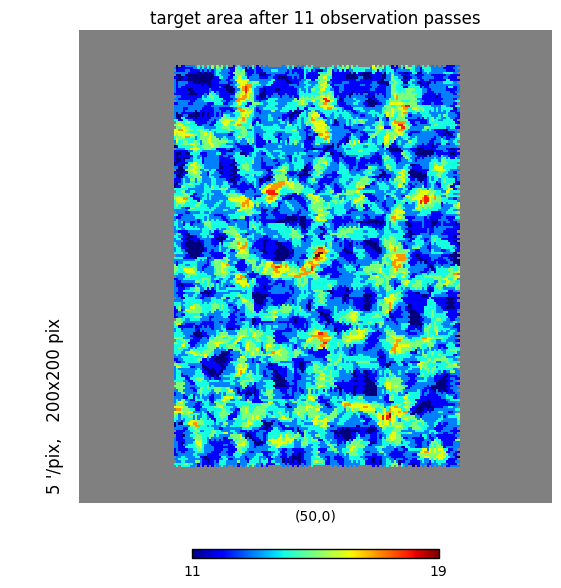

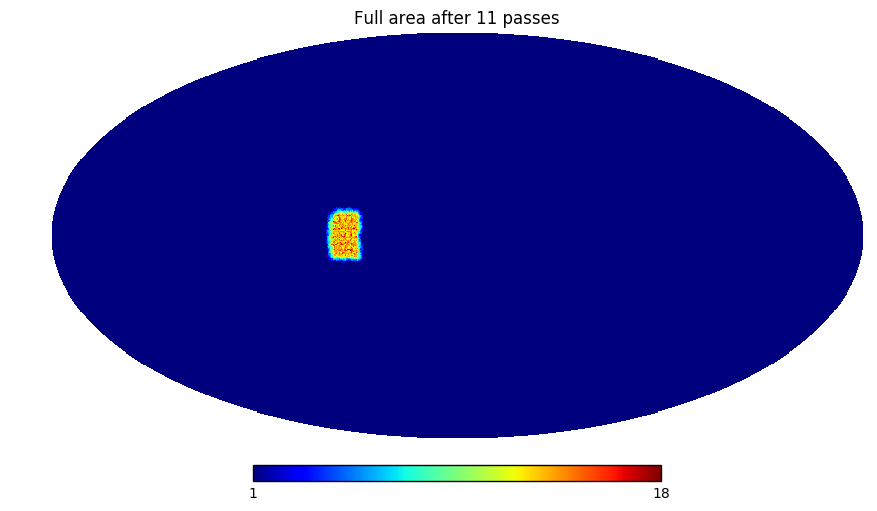

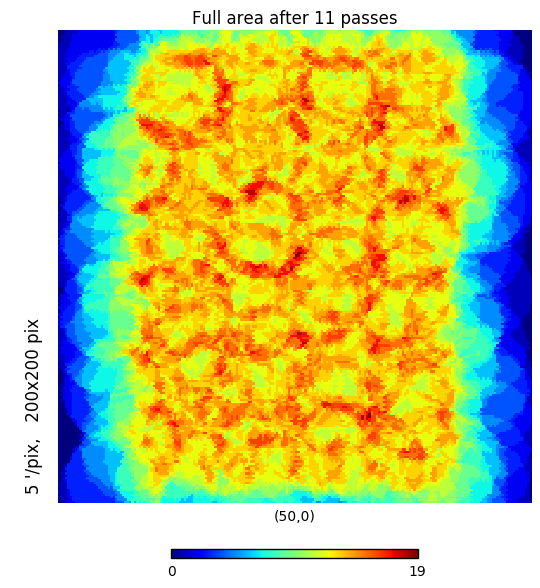

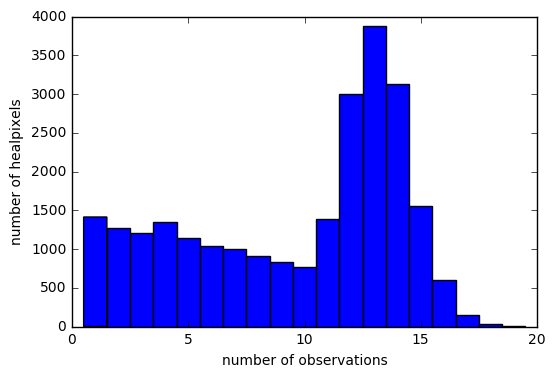

In [33]:
print np.degrees(best_fit)
hp.mollview(hpc.inmap, title='target area after 11 observation passes')
plt.figure()
good = np.where(hpc.inmap != hp.UNSEEN) #np.where(obs_map > 0)
plt.hist(obs_map[good], bins=np.arange(obs_map[good].min(),obs_map[good].max()+2,1 )-.5)
hp.gnomview(hpc.inmap, rot=(50, 0, 0), reso=5, title='target area after 11 observation passes')
plt.xlabel('number of observations')
plt.ylabel('number of healpixels')
hp.mollview(obs_map, min=1, title='Full area after 11 passes')
hp.gnomview(obs_map, rot=(50, 0, 0), reso=5, title='Full area after 11 passes')
plt.figure()
good = np.where(obs_map > 0) #np.where(obs_map > 0)
plt.hist(obs_map[good], bins=np.arange(obs_map[good].min(),obs_map[good].max()+2,1 )-.5)
plt.xlabel('number of observations')
plt.ylabel('number of healpixels')

In [30]:
# look at all the best fit values
np.degrees(bfs)

array([[  5.00146514e+01,  -1.44710892e+00,  -9.12129933e-02],
       [  5.06023042e+01,   3.48463895e-01,  -6.15210485e+01],
       [  5.22148745e+01,  -3.69540790e+00,  -3.04795156e+01],
       [  4.93945502e+01,  -3.47604144e+00,   1.38733654e+00],
       [  5.14437791e+01,   5.87638734e-02,   6.47298487e+01],
       [  4.70049236e+01,   2.15001286e-01,  -3.40166818e+01],
       [  4.91902605e+01,  -1.37642349e+00,  -2.54664976e+00],
       [  4.83044501e+01,  -2.32842590e+00,  -7.21826641e+01],
       [  4.99143129e+01,  -2.26916915e+00,  -3.29828276e+01],
       [  4.78882683e+01,   2.09654508e+00,   5.66577768e+01]])

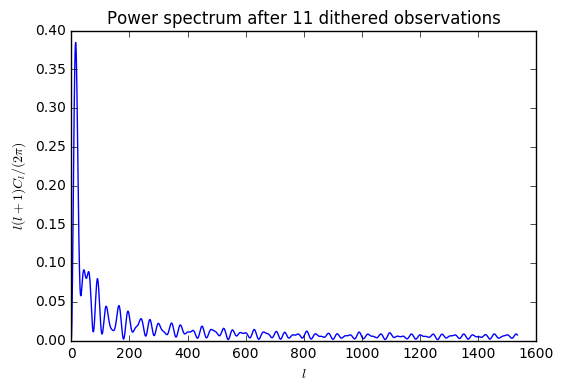

In [31]:
masked_map = obs_map.copy() +0.
masked_map[mask] = hp.UNSEEN
cl = hp.anafast(masked_map)
ell = np.arange(np.size(cl))
plt.plot(ell, (cl * ell * (ell + 1)) / 2.0 / np.pi)
plt.xlabel(r'$l$')
plt.ylabel(r'$l(l+1)C_l/(2\pi)$')
plt.title('Power spectrum after 11 dithered observations')